# Finetuned example

First install LLaVA https://github.com/haotian-liu/LLaVA

Finetune models can be found here: https://drive.google.com/drive/folders/1Uf152As_kBsRHR7seazHduvX7N0b8-Dq?usp=sharing

### Utils

In [13]:
### To run finetuned models Do !pip install transformers==4.31.0
### ONE CAN NOT RUN THE SENTENCE TRANSFORMERS (transformers==4.41.0)
import torch
from llava.constants import (
    IMAGE_TOKEN_INDEX,
    DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
    IMAGE_PLACEHOLDER,
)
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import (
    process_images,
    tokenizer_image_token,
    get_model_name_from_path,
    KeywordsStoppingCriteria,
)

CONTROLLER_HEART_BEAT_EXPIRATION = 30
WORKER_HEART_BEAT_INTERVAL = 15

LOGDIR = "."

# Model Constants
IGNORE_INDEX = -100
IMAGE_TOKEN_INDEX = -200
DEFAULT_IMAGE_TOKEN = "<image>"
DEFAULT_IMAGE_PATCH_TOKEN = "<im_patch>"
DEFAULT_IM_START_TOKEN = "<im_start>"
DEFAULT_IM_END_TOKEN = "<im_end>"
IMAGE_PLACEHOLDER = "<image-placeholder>"

import requests
from PIL import Image
from io import BytesIO
import re


def finetuned_model_predict(tokenizer, model, image_processor, prompt, source_image, target_image):
    # image index to use
    # Load images
    source_image = source_image.resize((target_image.width, target_image.height))

    image = concat_images(target_image, source_image)
    global args
    args = type('Args', (), {
        "model_name": 'llava-v1.5-7b',
        "query": prompt,
        "conv_mode": None,
        "image_file": image,
        "sep": ",",
        "temperature": 0,
        "top_p": None,
        "num_beams": 1,
        "max_new_tokens": 512
    })()

    return inference(args, tokenizer, model, image_processor)

# Function to concatenate images
def concat_images(*images):
    """Generate composite of all supplied images."""
    # Get the widest width.
    height = max(image.height for image in images)
    # Add up all the heights.
    width = sum(image.width for image in images)
    composite = Image.new('RGB', (width, height))
    # Paste each image below the one before it.
    y = 0
    for image in images:
        composite.paste(image, (y, 0))
        y += image.height
    return composite

# LLaVA inference script
def inference(args, tokenizer, model, image_processor):
    qs = args.query
    image_token_se = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
    if IMAGE_PLACEHOLDER in qs:
        if model.config.mm_use_im_start_end:
            qs = re.sub(IMAGE_PLACEHOLDER, image_token_se, qs)
        else:
            qs = re.sub(IMAGE_PLACEHOLDER, DEFAULT_IMAGE_TOKEN, qs)
    else:
        if model.config.mm_use_im_start_end:
            qs = image_token_se + "\n" + qs
        else:
            qs = DEFAULT_IMAGE_TOKEN + "\n" + qs

    if "llama-2" in args.model_name.lower():
        conv_mode = "llava_llama_2"
    elif "v1" in args.model_name.lower():
        conv_mode = "llava_v1"
    elif "mpt" in args.model_name.lower():
        conv_mode = "mpt"
    else:
        conv_mode = "llava_v0"

    if args.conv_mode is not None and conv_mode != args.conv_mode:
        print(
            "[WARNING] the auto inferred conversation mode is {}, while `--conv-mode` is {}, using {}".format(
                conv_mode, args.conv_mode, args.conv_mode
            )
        )
    else:
        args.conv_mode = conv_mode

    conv = conv_templates[args.conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()
    
    images_tensor = process_images(
        [args.image_file],
        image_processor,
        model.config
    ).to(model.device, dtype=torch.float16)

    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    global testt
    testt = [model, input_ids, images_tensor, True if args.temperature > 0 else False, args.temperature, args.top_p, args.num_beams, args.max_new_tokens, True, [stopping_criteria]]
    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=images_tensor,
            do_sample=True if args.temperature > 0 else False,
            temperature=args.temperature,
            top_p=args.top_p,
            num_beams=args.num_beams,
            max_new_tokens=args.max_new_tokens,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
        )

    input_token_len = input_ids.shape[1]
    n_diff_input_output = (input_ids != output_ids[:, :input_token_len]).sum().item()
    if n_diff_input_output > 0:
        print(
            f"[Warning] {n_diff_input_output} output_ids are not the same as the input_ids"
        )
    outputs = tokenizer.batch_decode(
        output_ids[:, input_token_len:], skip_special_tokens=True
    )
    
    prediction = ' '.join([s if s.endswith('.') else s + '.' for s in outputs])
    return prediction

import matplotlib.pyplot as plt
def display_side_by_side(source_img, target_img):
    # Assuming target_img and source_img are already loaded as PIL Image objects
    # from the previous code block

    # Create a figure and a set of subplots (1 row, 2 columns)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # Adjust figsize as needed

    # Display the source image in the first subplot (reversed order)
    axes[0].imshow(source_img)
    axes[0].set_title("Source Image")
    axes[0].axis('off') # Hide axes

    # Display the target image in the second subplot (reversed order)
    axes[1].imshow(target_img)
    axes[1].set_title("Target Image")
    axes[1].axis('off') # Hide axes

    # Adjust layout to prevent titles/images overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

### Load Model

In [15]:
FINETUNE_MODEL_PATH = 'FINETUNE_MODEL_PATH'

from llava.model.builder import load_pretrained_model
from llava.eval.run_llava import eval_model

model_base = "liuhaotian/llava-v1.5-7b"
model_name = "llava-v1.5-7b-task-lora"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=FINETUNE_MODEL_PATH,
    model_name=model_name,
    model_base=model_base
)

### Load Images

In [8]:
import requests
from PIL import Image
from io import BytesIO

target_img = Image.open(BytesIO(requests.get('https://iili.io/FKKpk9j.md.png').content)).resize((500, 500))
source_img = Image.open(BytesIO(requests.get('https://iili.io/FKKpvAx.md.png').content)).resize((500, 500))

### Prediction

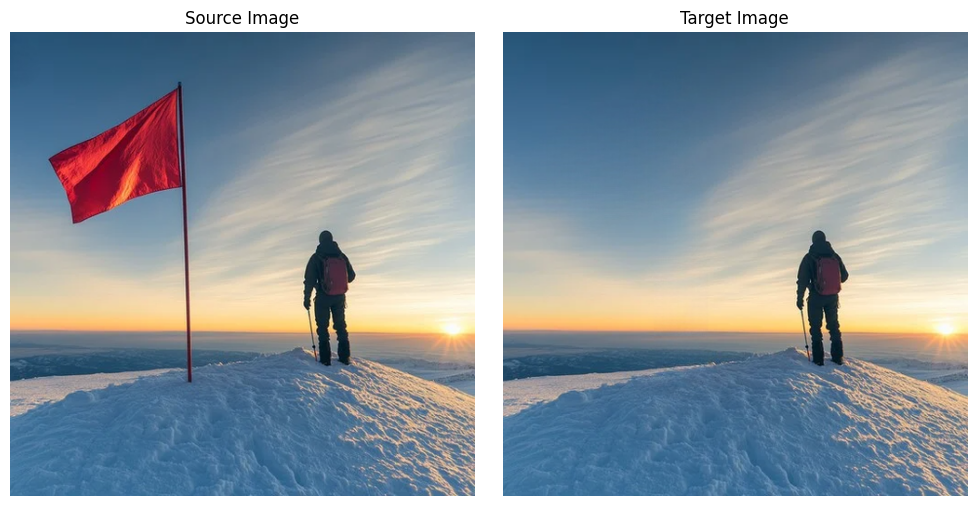

In [14]:
display_side_by_side(source_img, target_img)

In [7]:
difference_caption_generation_prompt = open('prompts/detect_the_difference_prompt.txt', "r").read()
finetuned_model_predict(tokenizer, model, image_processor, difference_caption_generation_prompt, source_img, target_img)

The red flag was removed from the snowy mountain top.
